## Install waymo_open_dataset package

In [1]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/r1.0
!pip3 install --upgrade pip

!pip3 install waymo-open-dataset
import os
import tensorflow as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

Cloning into 'waymo-od'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 516 (delta 91), reused 95 (delta 52), pack-reused 363
Receiving objects: 100% (516/516), 14.06 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (283/283), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
Note: checking out 'remotes/origin/r1.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at a66eb0a Merge branch 'master' into r1.0
Requirem

## Mount google drive

Please make sure you added the share folder to your drive

In [2]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load frames

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [3]:
from os import listdir
from os.path import isfile, join

# Uploaded manually
files = ['/content/gdrive/My Drive/waymo-dataset-urban-no-lane-chaning-car-following-tfrecord-files/training/training_0000_segment-14143054494855609923_4529_100_4549_100_with_camera_labels.tfrecord']

# For visualization: https://drive.google.com/drive/u/0/folders/1-CXDJwgd96fTHHboekfdyIxVj2lzjf1n

for i in range(len(files)):
    file = files[i]
    dataset = tf.data.TFRecordDataset(file, compression_type='')
    
    # Load frames from dataset
    frames = []
    for data in dataset:
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        frames.append(frame)
        
    print("filename:", file, "Num of frames:", len(frames))

filename: /content/gdrive/My Drive/waymo-dataset-urban-no-lane-chaning-car-following-tfrecord-files/training/training_0000_segment-14143054494855609923_4529_100_4549_100_with_camera_labels.tfrecord Num of frames: 198


## Helper functions

In [0]:
from shapely.geometry import Polygon, LineString

def intersects(label):
  # Starting from the upper-left corner, clock direction
  bounding_box = Polygon([
      (label.box.center_x - 0.5 * label.box.length, label.box.center_y + 0.5 * label.box.width), 
      (label.box.center_x + 0.5 * label.box.length, label.box.center_y - 0.5 * label.box.width), 
      (label.box.center_x + 0.5 * label.box.length, label.box.center_y + 0.5 * label.box.width),
      (label.box.center_x - 0.5 * label.box.length, label.box.center_y - 0.5 * label.box.width)
  ])
  
  line = LineString([(0, 0), (label.box.center_x, 0)])
  
  return bounding_box.intersects(line)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def find_corresponding_projected_lidar_label(frame, front_car_laser_label):
  for pll_wrapper in frame.projected_lidar_labels:
    if pll_wrapper.name != FRONT:
      continue
      
    for pll in pll_wrapper.labels:
      if front_car_laser_label.id in pll.id:
        return pll
      
  return None

def show_label_on_image(camera_image, label, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

      # Draw the object bounding box.
  ax.add_patch(patches.Rectangle(
      xy=(label.box.center_x - 0.5 * label.box.length,
          label.box.center_y - 0.5 * label.box.width),
      width=label.box.length,
      height=label.box.width,
      linewidth=1,
      edgecolor='red',
      facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

  plt.figure(figsize=(25, 20))

  
def verify_front_car_label(frame, front_car_label):
  """
  Display the bounding box of the found front car on the image to verify if the 
  front car is captured correctly.
  """
  for index, image in enumerate(frame.images):
    front_car_pll = find_corresponding_projected_lidar_label(frame, front_car_label)
    if front_car_pll is not None:
      show_label_on_image(image, front_car_pll, [3, 3, index + 1])
    break
    

## Feature extraction

In [0]:
import random
import numpy as np

TYPE_VEHICLE = 1
FRONT = 1
FPS = 10
VERIFY_THRESHOLD = 0.05

def collect_vehicle_laser_labels(frame):
  v_laser_labels = []
  
  for ll in frame.laser_labels:
    v_laser_labels.append(ll)
      
  return v_laser_labels


def get_front_car_laser_label(labels):
  """
  Find the closest bounding box which intersects with y = 0 and its center_x is positive
  """
  
  front_car_label = None
  
  for label in labels:
    if label.box.center_x < 0:
      continue 
      
    if intersects(label):
      if front_car_label is None or front_car_label.box.center_x > label.box.center_x:
        front_car_label = label
      
  return front_car_label


def cal_aceleration(v1, v2, dt):
  return (v2 - v1) / dt;

## Write/read features and labels to/from csv file

In [0]:
import numpy as np

def write_to_csv(filename, feats, labels):
  comb_np = np.hstack((feats, labels))
  np.savetxt(filename, comb_np, delimiter=",")
  
  
def read_from_csv(filename):
  data = np.genfromtxt(filename, delimiter=',')
  return data

In [0]:
"""
features:
[vx, vy, vz, dx, dy, vfx, vfy, vfz, afx, afy, afz]

labels:
[ax, ay, az]
"""


def get_vehicle_pose(frame):
  pose = []
  for image in frame.images:
      pose = [t for t in image.pose.transform]
 
  return np.asarray(pose).reshape((4,4))


def get_current_car_velocity_wrt_GF(frame):
  """
  Return the speed v_x and v_y of the current car
  """
  for image in frame.images:
    return np.asarray([image.velocity.v_x, image.velocity.v_y, image.velocity.v_z])
  
  return None


def get_front_car_velocity_wrt_GF(front_car_label, vehicle_pose, v_cur_GF): 
  v_front_VF = np.asarray([front_car_label.metadata.speed_x, front_car_label.metadata.speed_y, 0])
  _v_front_VF = np.hstack((v_front_VF, [0])) # padded 0 for matrix multiplication
  return np.matmul(vehicle_pose, _v_front_VF)[:3] - v_cur_GF


def get_relative_distance(front_car_label):
  return np.asarray([front_car_label.box.center_x, front_car_label.box.center_y])


def get_current_car_accel_GF_per_frame(dt, v_cur_GF, v_cur_GF_prev):
  return cal_aceleration(v_cur_GF, v_cur_GF_prev, dt) if v_cur_GF_prev is not None else np.asarray([0, 0, 0])


def get_front_car_GF_features_per_frame(dt, frame, vehicle_pose, v_cur_GF, v_front_GF_prev, verify=False):
  v_laser_labels = collect_vehicle_laser_labels(frame)
  front_car_label = get_front_car_laser_label(v_laser_labels)
  
  if verify and random.random() < VERIFY_THRESHOLD:
    verify_front_car_label(frame, front_car_label)
    
  relative_dist = get_relative_distance(front_car_label) # 2 * 1
  v_front_GF = get_front_car_velocity_wrt_GF(front_car_label, vehicle_pose, v_cur_GF) # 3 * 1
  a_front_GF = cal_aceleration(v_front_GF, v_front_GF_prev, dt) if v_front_GF_prev is not None else np.asarray([0, 0, 0]) # 3 * 1
  
  return np.hstack((relative_dist, v_front_GF, a_front_GF)), v_front_GF


def get_essentials_per_frame(dt, frame, v_cur_GF_prev, v_front_GF_prev):
  vehicle_pose = get_vehicle_pose(frame)
  v_cur_GF = get_current_car_velocity_wrt_GF(frame) # 3 * 1
  front_GF_feat, v_front_GF = get_front_car_GF_features_per_frame(dt, frame, vehicle_pose, v_cur_GF, v_front_GF_prev) # 8 * 1 
  a_cur_GF = get_current_car_accel_GF_per_frame(dt, v_cur_GF, v_cur_GF_prev) # 3 * 1
  
  return np.hstack((v_cur_GF, front_GF_feat)), a_cur_GF, v_cur_GF, v_front_GF


def get_features_and_labels(frames):
  feat_set = []
  label_set = []
  
  dt = len(frames) * 1.0 / FPS / (len(frames) - 1)
  
  # init
  v_cur_GF_prev = None
  v_front_GF_prev = None
  
  for frame in frames:
    feats, labels, v_cur_GF_prev, v_front_GF_prev = get_essentials_per_frame(dt, frame, v_cur_GF_prev, v_front_GF_prev)
    feat_set.append(feats)
    label_set.append(labels)
    
  return np.asarray(feat_set), np.asarray(label_set)


In [0]:
feats, labels = get_features_and_labels(frames)

write_to_csv("data.csv", feats, labels)

## Plots

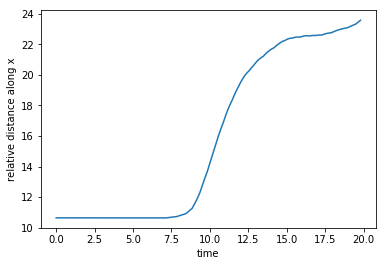

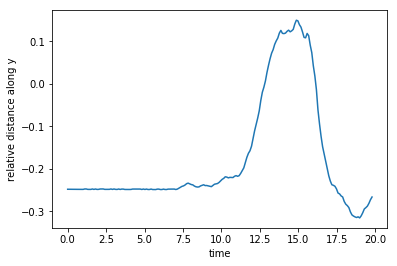

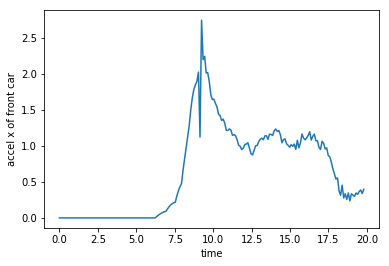

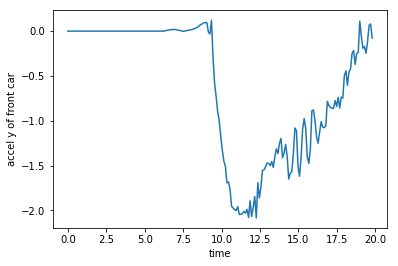

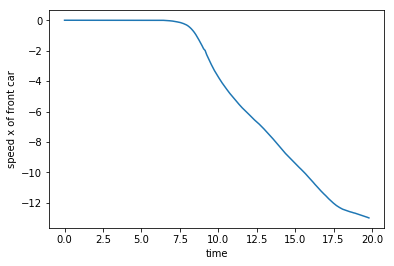

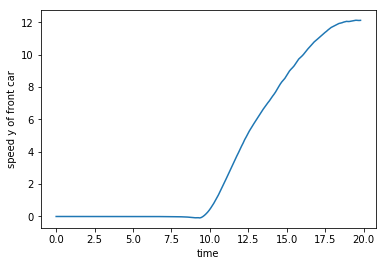

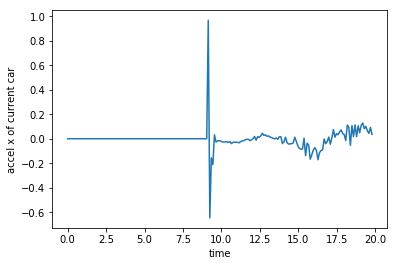

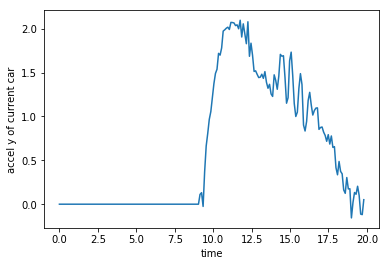

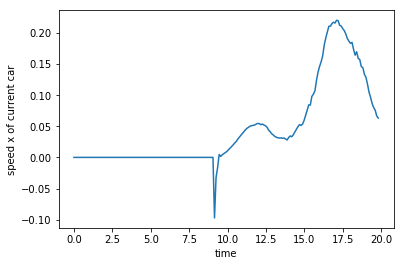

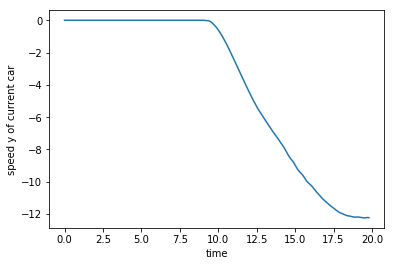

In [11]:
import matplotlib.pyplot as plt

NUM_FRAMES = len(frames)
DT = NUM_FRAMES * 1.0 / FPS / (NUM_FRAMES - 1)

VX = 0
VY = 1
VZ = 2
DX = 3
DY = 4
VFX = 5
VFY = 6
VFZ = 7
AFX = 8
AFY = 9
AFZ = 10

AX = 0
AY = 1

times = [t * DT for t in range(0, len(feats))] 

vfxs = []
vfys = []
afxs = []
afys = []
axs = []
ays = []
vxs = []
vys = []

dxs = []
dys = []

for i in range(len(feats)):
  
  dxs.append(feats[i][DX])
  dys.append(feats[i][DY])
  vfxs.append(feats[i][VFX])
  vfys.append(feats[i][VFY])
  afxs.append(feats[i][AFX])
  afys.append(feats[i][AFY])
  vxs.append(feats[i][VX])
  vys.append(feats[i][VY])
  axs.append(labels[i][AX])
  ays.append(labels[i][AY])

plt.plot(times, dxs)
plt.ylabel('relative distance along x')
plt.xlabel('time')
plt.show()

plt.plot(times, dys)
plt.ylabel('relative distance along y')
plt.xlabel('time')
plt.show()

plt.plot(times, afxs)
plt.ylabel('accel x of front car')
plt.xlabel('time')
plt.show()

plt.plot(times, afys)
plt.ylabel('accel y of front car')
plt.xlabel('time')
plt.show()

# For verification
plt.plot(times, vfxs)
plt.ylabel('speed x of front car')
plt.xlabel('time')
plt.show()

plt.plot(times, vfys)
plt.ylabel('speed y of front car')
plt.xlabel('time')
plt.show()

plt.plot(times, axs)
plt.ylabel('accel x of current car')
plt.xlabel('time')
plt.show()

plt.plot(times, ays)
plt.ylabel('accel y of current car')
plt.xlabel('time')
plt.show()

plt.plot(times, vxs)
plt.ylabel('speed x of current car')
plt.xlabel('time')
plt.show()

plt.plot(times, vys)
plt.ylabel('speed y of current car')
plt.xlabel('time')
plt.show()
